# Maps of gas applicance capacity per ACT administrative block

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import contextily as cx
import matplotlib.pyplot as plt

## Analysis Parameters

In [2]:
dataset_path = '/g/data/os22/chad_tmp/NEE_modelling/notebooks/Mitchell_Type_B.csv'
division_name = 'MITCHELL'
save_path = '/g/data/os22/chad_tmp/NEE_modelling/results/figs/'

## Open 'Block' dataset

Clip to the Division of interest e.g.Mitchell


Block dataset was acquired from here: https://actmapi.act.gov.au/datadownload/Shapefile/MGA94_55/


In [3]:
block_path='/g/data/os22/chad_tmp/NEE_modelling/notebooks/ACT_Blocks.geojson'
block = gpd.read_file(block_path)

In [4]:
division = block[block['DIVISION_N']==division_name]

## Open gas dataset and aggegate (sum) by section/block

In [5]:
df = pd.read_csv(dataset_path)
df = df.rename({'Block':'BLOCK', 'Section': 'SECTION'}, axis=1)

In [6]:
gas_type = df[["SECTION","BLOCK", 'Type of Gas']].drop_duplicates()

In [7]:
df = df.groupby(["SECTION","BLOCK"]).sum('MJ/Hr rating')

In [8]:
df = pd.merge(df, gas_type, on=['SECTION', 'BLOCK'])

## Merge Blocks with gas appliance data

In [9]:
dff = pd.merge(division, df, on=['SECTION', 'BLOCK'])
dff = dff.to_crs('EPSG:3577')
dff["geometry"] = dff["geometry"].centroid

## Check for section/block values that are not in the 'Block' dataset

In [10]:
missing = pd.concat([(df.reset_index())[["SECTION","BLOCK"]], dff[["SECTION","BLOCK"]]]).drop_duplicates(keep=False)
missing

,SECTION,BLOCK


## Make a plot of the gas appliance capacity

### Map with different sized symbols based on MJ/hr

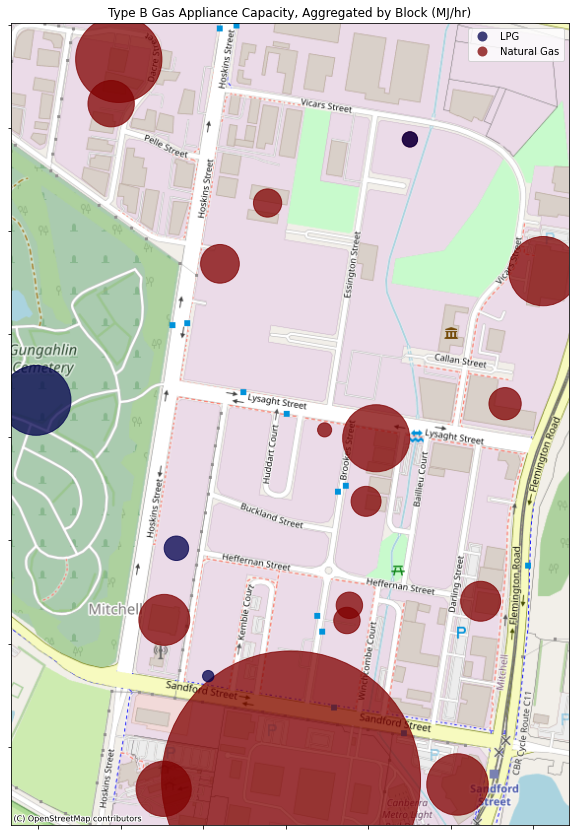

In [17]:
fig, ax = plt.subplots(figsize=(10, 20))
dff.to_crs(epsg=3857).plot(column='Type of Gas',
                           cmap='seismic',
                           markersize='MJ/Hr rating',
                           alpha=0.75,
                           ax=ax,
                           legend=True,
                          )
ax.set_xticklabels([])
ax.set_yticklabels([])
cx.add_basemap(ax,
               source=cx.providers.OpenStreetMap.Mapnik,
            # source='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
              )
plt.title('Type B Gas Appliance Capacity, Aggregated by Block (MJ/hr)');
# plt.savefig(save_path+'gas_capacity_'+division_name+'.png', bbox_inches='tight')

## Interactive web map

In [29]:
dff.explore(column='Type of Gas',
           cmap='seismic',
           marker_kwds={'radius':7},
           legend=True
          )